# Prey Predator Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 25/Aug/2020 18:38

# Prey Predator dynamics on SD and ABM

On this notebook, we'll explore and visualize how P&P behave both in a dynamic system approach and in an agent-based one. Both models were written on cadCAD - a library for Complex Adaptive Dynamics simulations which allows you to mix and prototype different modelling paradigms in a reproducible and consistent manner.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Experiments
import run

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 6, 1, 2)



Execution Method: local_simulations
SimIDs   : [0, 1]
SubsetIDs: [0, 0]
Ns       : [0, 0]
ExpIDs   : [0, 0]
Execution Mode: parallelized



Total execution time: 28.14s
Execution in 28.2s


### Dynamical System: Lotka-Volterra

This is the standard introductory model for Prey-Predator interactions and dynamical systems in general. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Prey}&=\alpha * Prey-\beta * Prey * Predators,\\{\frac {d}{dt}Predators}&=\delta * Prey * Predators-\gamma * Predators,\end{aligned}

Where $\alpha$ and $\gamma$  are the prey growth rate and predator elimination rate, and $\delta$ and $\gamma$ are interaction factors between preys and predators.

The most prominent feature of it is the existence, depending on the choice of parameters, of a repeteable cycle around a fixed point which creates a dynamical equilibrium between the number of preys and predators on a system.

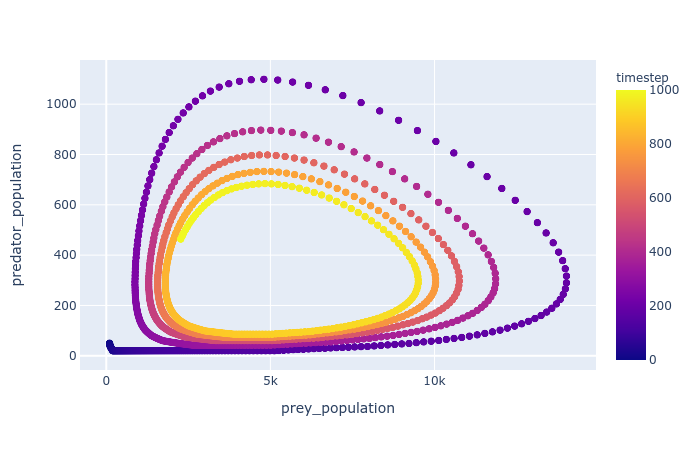

In [4]:
fig = px.scatter(experiments.dataset[0],
                 x='prey_population',
                 y='predator_population',
                 color='timestep')

fig.show('png')

## Agent-based modelling

There are a lot of possible ABMs for any given phenomenon. cadCAD allows you to add, modify and remove simulation blocks and steps at will. 

For this demo, we'll adopt a model based on a grid world, on which preys and predators take the following actions at each timestep of their lifes:

1. Food is grown on every site.
2. All agents digest some of the food on their stomach and get older.
3. All agents move (if possible) to an available random neighboring location.
4. The agents reproduce themselves if there is an available partner nearby
5. The prey agents feed on the available food
6. The predator agents hunts the nearby preys
7. All old enough agents die

There is an inherent stochastic nature on this model, and every time that you run it, we'll have a completely different result for the same parameters. But we can see that there is sort of a random equilibrium that converges to the dynamical equilibrium which we presented on the dynamical simulation.

ABMs tend to produce rich, high density datasets. We'll plot some of this data, but invite the reader to fork this repository and trace the network relations between the agents, or the geospatial statistics around the ABM, for example.

In [5]:
# Get the ABM results
agent_ds = experiments.dataset[1].agents
site_ds = experiments.dataset[1].sites
timesteps = experiments.dataset[1].timestep

In [6]:
# Get metrics

## Agent quantity
prey_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'prey']))
predator_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'predator']))


## Food quantity
food_at_sites = site_ds.map(lambda s: s.sum())
food_at_prey = agent_ds.map(lambda s: sum([agent['food'] 
                                           for agent 
                                           in s.values() if agent['type'] == 'prey']))
food_at_predators = agent_ds.map(lambda s: sum([agent['food'] 
                                                for agent in s.values() 
                                                if agent['type'] == 'predator']))

## Food metrics
median_site_food = site_ds.map(lambda s: np.median(s)) 
median_prey_food = agent_ds.map(lambda s: np.median([agent['food'] 
                                                     for agent in s.values() 
                                                     if agent['type'] == 'prey']))
median_predator_food = agent_ds.map(lambda s: np.median([agent['food'] 
                                                         for agent in s.values() 
                                                         if agent['type'] == 'predator']))

## Age metrics
prey_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'prey']))
predator_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'predator']))

# Create an analysis dataset
data = (pd.DataFrame({'timestep': timesteps,
                      'prey_count': prey_count,
                      'predator_count': predator_count,
                      'food_at_sites': food_at_sites,
                      'food_at_prey': food_at_prey,
                      'food_at_predators': food_at_predators,
                      'median_site_food': median_site_food,
                      'median_prey_food': median_prey_food,
                      'median_predator_food': median_predator_food,
                      'prey_median_age': prey_median_age,
                      'predator_median_age': predator_median_age})       
       )

### A temporal summary for the simulation

On the following plot, we can see how the prey, predator and available food changes along time. Can you see any cyclical patterns?

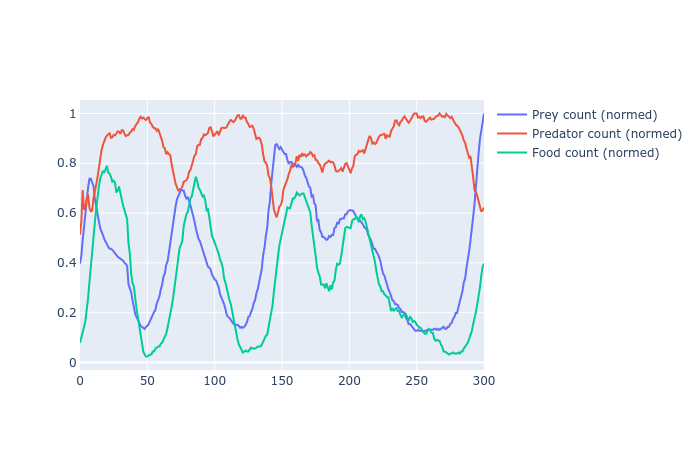

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=timesteps, 
                         y=prey_count / prey_count.max(),
                         mode='lines',
                         name='Prey count (normed)'))


fig.add_trace(go.Scatter(x=timesteps, 
                         y=food_at_sites / food_at_sites.max(),
                         mode='lines',
                         name='Predator count (normed)'))


fig.add_trace(go.Scatter(x=timesteps, 
                         y=predator_count / prey_count.max(),
                         mode='lines',
                         name='Food count (normed)'))

fig.show('png')

### Prey predator phase space

Note that it sorts of converges, in a chaotic manner, to the dynamical system model

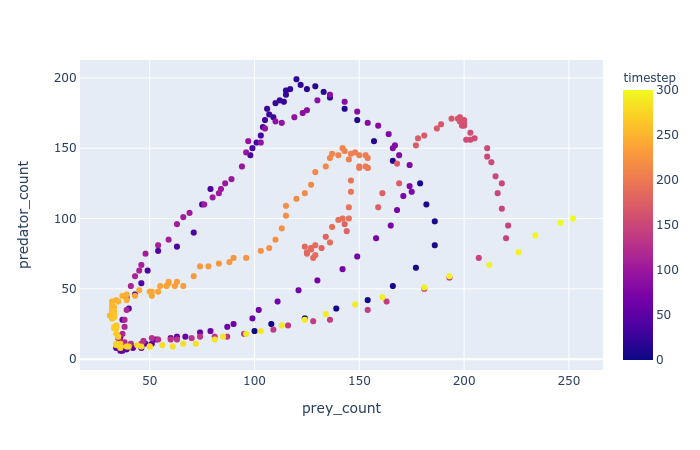

In [8]:
fig = px.scatter(data,
                 x='prey_count',
                 y='predator_count',
                 color='timestep')
fig.show('png')

### Prey prevalence vs food availability on the world

There is an inverse relation between the available food on the grid, and the number of prey.

From the code, can you tell why there is higher variance when the number of prey is higher?

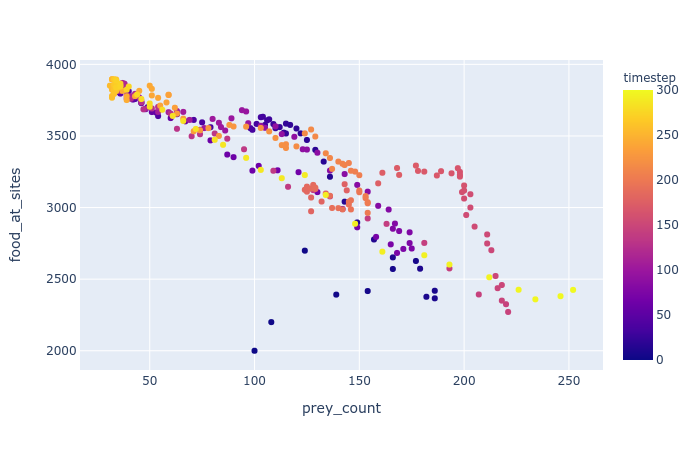

In [9]:
fig = px.scatter(data,
                 x='prey_count',
                 y='food_at_sites',
                 color='timestep')
fig.show('png')

#### Food inside agents stomachs

On average, the prey stomachs are always quite full, while the predators stomachs contents vary more.

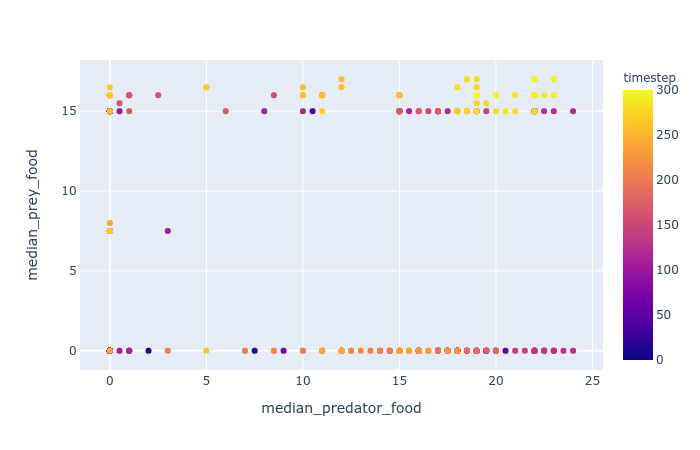

In [10]:
fig = px.scatter(data,
                 x='median_predator_food',
                 y='median_prey_food',
                 color='timestep')
fig.show('png')

### Brute force plotting

There are a lot of patterns to explore and extract knowlodge. On the following plot, you can see all pairwise variable comparisons. Can you notice anything interesting worth investigating further?

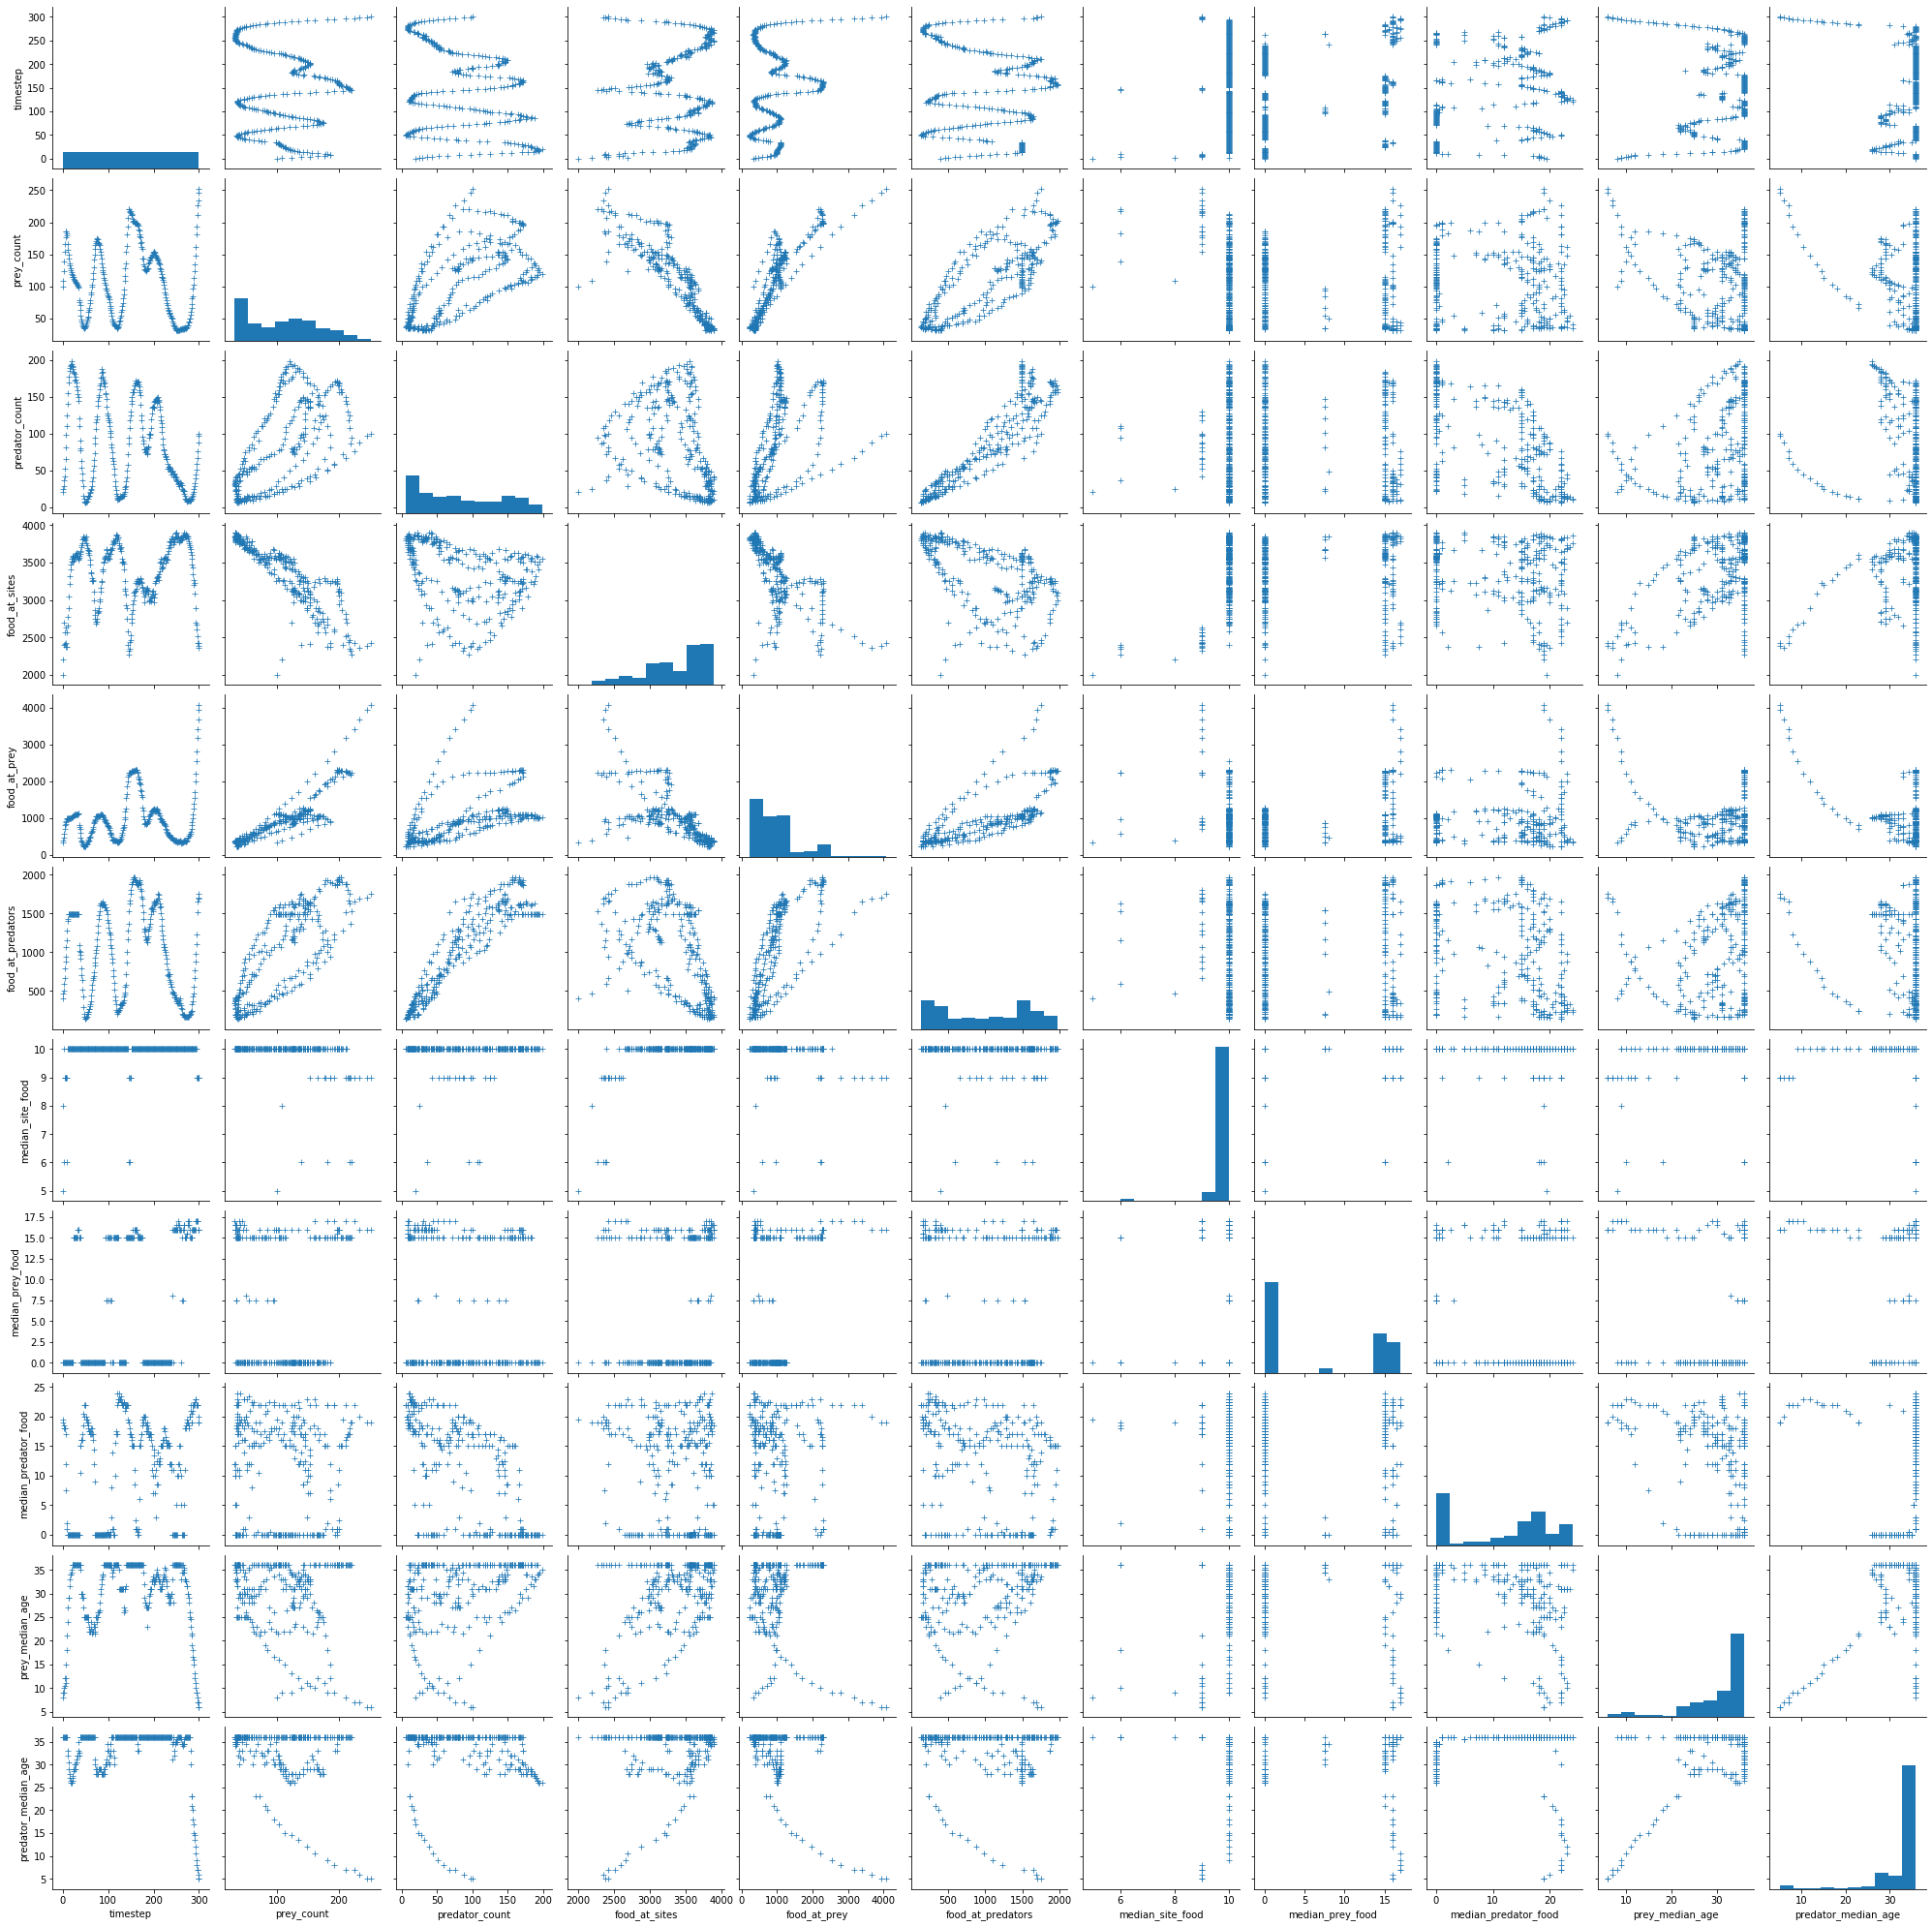

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data=data, 
             diag_kind='hist', 
             markers='+')
plt.show('png')

### Conclusions and final words

We explored here two different paradigms for modelling: the dynamic system one, which captures an macroscopical view of the system, and the agent-based one, which can give us an microscopic view of the system. Depending on the targets and considerations, both can be equivalent or completely distinct, but can also be complementary. cadCAD allows you to mix them at will, so you can have hybrid models where agent behaviour and environment are shaped by complex dynamical systems. There is an whole multiverse of mixed simulations that you can do (challenges on next block for you to try!).

Obviously, both paradigms have some characteristics, which in general manner we can express as being:

#### Dynamical system (macroscopic view) advantages

* Fast-performing, allowing a very large number of timesteps and simulations
* Easier to prototype and to add/modify mechanisms
* Easier to insert a multitude of complex factors
* The output is usually easy to visualize
* Inner workings are more transparent

#### Agent-based modelling (microscopic view) advantages

* Are conceptually closer to experience, making it easier to explain to someone with no previous background
<!---* There is more allowance on stochastic mechanisms and logic--->
* Easier to generate complex behaviour with simple rules
* Generates more granular and detailed information
* Inner workings have more depth


### Proposed challenges

#### Find the equivalent models

Use cadCAD's support for Monte Carlo simulations and parameter sweeping to find a set of parameters that, in expectation, results in nearly equivalent results for the populations of preys and predators over time in both models. You'll need to run multiple Monte Carlo runs of the ABM model and aggregate the results.

#### Sazonability of food growth

A quick way to mix the ABM and SD paradigms is the following: what if the food growth depends on an dynamical system? 

You can model that by modifying the food growth policy, such as by inserting a sazonability which depends on the timestep for example. Or you could go even further and try to express it as depending on an irradiance-based dynamical system which models the Sun position according to Earth's movements (rotation, translation, recession and nutation). How much do you think that those layers of additional complexity will add to the knowledge behind the physical system which we are modelling?

#### Stochasticity of the agents decisions

In the current model, all randomness is derived from the agents' position on the grid relative to other agents. What if there was also some probability $p_i$ associated with each one of the actions (moving, eating, reproducing)? And what if the decision also depended on the state of the system near the agent, such as the presence of a predator and food availability?

#### Agent death by exponential probability

All agents die when the maximum lifespan arrives. Can you modify the ABM for having an associated spontaneous death probability according to exponential distribution? Something which makes almost all young agents live, but most old ones to die? What if this probability is also a function of an indicator of the agent's health, such as the amount of food in their stomach?

#### Prey evolution & adaptation

This is the master challenge :-)  What if the preys had a varying attribute which gave them some competitive advantage over others? For example, a number of lifes, like in a videogame, or speed, reproduction rate, or different lifespans? What if those attributes were passed on their offspring with some mutation probability? Could we see an initial random population of preys evolve into a stronger set?